## Predicting Bigg Boss Hindi (बिग बॉस हिंदी) Season 13 Winner

## Using Python scikit learn https://satya-python.blogspot.com/

### Importing Required Python Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

### Import dataset

In [2]:
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")
nRow, nCol = bigg_boss.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 546 rows and 21 columns


## Exploratory Data Analysis (EDA)

In [3]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,3.0,2.72,0.0,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,6.0,2.72,0.0,0.0,0.0


In [4]:
bigg_boss.tail(10).T

,536,537,538,539,540,541,542,543,544,545
Language,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam,Malayam
Season Number,1,1,1,1,1,1,1,1,1,1
Name,Hima Shankar,Manoj K. Verma,Pearle Maaney,Ranjini Haridas,Sabumon Abdusamad,Shweta Menon,Sreelakshmi Sreekumar,Srinish Aravind,Anjali Ameer,Shiyas Kareem
Profession,Actress,Businessman,Actress,TV Anchor,TV Anchor,Actress,Actress,Soap Actor,Actress,Actor
Gender,Female,Male,Female,Female,Male,Female,Female,Male,Female,Male
Entry Date,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,24-Jun-18,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,11,NaN,14,9,NaN,5,4,14,NaN,14
Wild Card,No,No,No,No,No,No,No,No,Yes,Yes
Season Length,98,98,98,98,98,98,98,98,98,98


In [5]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
285,Kannada,4,Karunya Ram,Actress,Female,09-Oct-16,NaN,NaN,No,112,18,09-Oct-16,29-Jan-17,Sudeep,0,Colors Kannada,NaN,NaN,NaN,NaN,0.0
116,Hindi,7,Candy Brar,Model,Female,NaN,NaN,8.0,Yes,105,20,15-Sep-13,28-Dec-13,Salman Khan,0,Colors,1.0,4.40,0.0,0.0,0.0
301,Kannada,5,Ashitha Chandrappa,Soap Actress,Female,15-Oct-17,NaN,8.0,No,106,20,15-Oct-17,28-Jan-18,Sudeep,0,Colors Kannada,2.0,NaN,0.0,0.0,0.0
166,Hindi,10,Navin Prakash,Commoner - Teacher,Male,16-Oct-16,NaN,4.0,No,105,18,16-Oct-16,28-Jan-17,Salman Khan,0,Colors,1.0,3.54,0.0,0.0,0.0
498,Bengali,1,Abhijeet Burman,Actor,Male,17-Jun-13,NaN,12.0,No,90,15,17-Jun-13,14-Sep-13,Mithun Chakraborthy,0,ETV Bangla,NaN,2.90,NaN,NaN,0.0
454,Tamil,3,Reshma Pasupuleti,Actress,Female,23-Jun-19,NaN,6.0,No,105,17,23-Jun-19,06-Oct-19,Kamal Haasan,0,Start Vijay,1.0,8.80,0.0,NaN,0.0
40,Hindi,3,Sherlyn Chopra,Actress,Female,04-Oct-09,NaN,3.0,No,84,15,04-Oct-09,26-Dec-09,Amitabh Bachchan,0,Colors,4.0,2.83,0.0,0.0,0.0
486,Marathi,2,Maitthily Jawkar,Actress,Female,26-May-19,NaN,2.0,No,98,17,26-May-19,01-Sep-19,Mahesh Manjrekar,0,Colors Marathi,1.0,NaN,0.0,0.0,0.0
347,Kannada,7,Gurulinga Swamy,Swamiji,Male,13-Oct-19,NaN,1.0,No,99,19,13-Oct-19,NaN,Sudeep,0,Colors Kannada,1.0,NaN,0.0,0.0,0.0
298,Kannada,4,Sukrutha Wagle,Actress,Female,NaN,NaN,NaN,Yes,112,18,09-Oct-16,29-Jan-17,Sudeep,0,Colors Kannada,NaN,NaN,NaN,NaN,0.0


In [6]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 21 columns):
Language                              546 non-null object
Season Number                         546 non-null int64
Name                                  546 non-null object
Profession                            546 non-null object
Gender                                546 non-null object
Entry Date                            471 non-null object
Elimination Date                      96 non-null object
Elimination Week Number               440 non-null float64
Wild Card                             546 non-null object
Season Length                         546 non-null int64
Number of Housemates                  546 non-null int64
Season Start Date                     546 non-null object
Season End Date                       527 non-null object
Host Name                             546 non-null object
Prize Money (INR)                     531 non-null object
Broadcasted By              

In [7]:
bigg_boss.describe()

,Season Number,Elimination Week Number,Season Length,Number of Housemates,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
count,546.000000,440.000000,546.000000,546.000000,470.000000,350.000000,472.000000,353.000000,518.000000
mean,4.697802,8.813636,99.871795,17.794872,3.821277,5.355886,0.084746,0.521246,0.055985
std,3.599474,4.583997,7.970936,1.762518,2.640906,2.312224,0.293634,0.761448,0.230114
min,1.000000,1.000000,70.000000,15.000000,0.000000,2.720000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,98.000000,16.250000,1.250000,3.540000,0.000000,0.000000,0.000000
50%,3.000000,9.000000,99.000000,18.000000,3.000000,4.700000,0.000000,0.000000,0.000000
75%,7.000000,13.000000,105.000000,19.000000,6.000000,7.800000,0.000000,1.000000,0.000000
max,13.000000,16.000000,112.000000,20.000000,12.000000,10.330000,2.000000,5.000000,1.000000


In [8]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col,"-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 13
Number of unique values in Name - 545
Number of unique values in Profession - 74
Number of unique values in Gender - 3
Number of unique values in Entry Date - 36
Number of unique values in Elimination Date - 53
Number of unique values in Elimination Week Number - 16
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 12
Number of unique values in Number of Housemates - 6
Number of unique values in Season Start Date - 31
Number of unique values in Season End Date - 28
Number of unique values in Host Name - 15
Number of unique values in Prize Money (INR) - 4
Number of unique values in Broadcasted By - 11
Number of unique values in Number of Evictions Faced - 13
Number of unique values in Average TRP - 19
Number of unique values in Number of re-entries - 3
Number of unique values in Number of times elected as Captain - 6
Number of unique values in Winner - 2


In [9]:
# Number of seasons in all Indian languages
print(bigg_boss.groupby('Language')['Season Number'].nunique().sum())

# 31 seasons happened (including current seasons)

31


## https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

## Bigg Boss Hindi has many seasons compared to other Indian languages. So, number of housemates are more in Hindi.

In [10]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi      13
Kannada     7
Tamil       3
Telugu      3
Bengali     2
Marathi     2
Malayam     1
Name: Season Number, dtype: int64


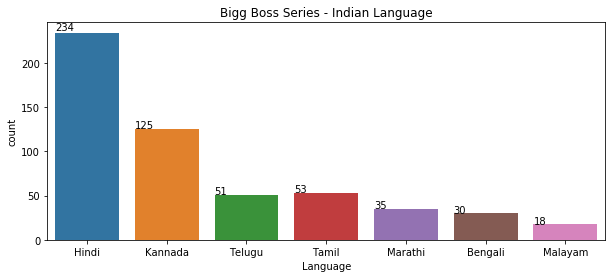

In [11]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10,4))
ax = sns.countplot(x='Language', data=bigg_boss)
ax.set_title('Bigg Boss Series - Indian Language')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates (85%) entered in first day/week

No     463
Yes     83
Name: Wild Card, dtype: int64 

No     85.0
Yes    15.0
Name: Wild Card, dtype: float64


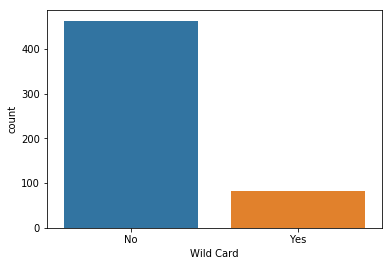

In [12]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100))
sns.countplot(x='Wild Card', data=bigg_boss)

## Number of film actress entered into the Bigg Boss houses, are more when compared to other professions 

Actress                            127
Actor                               92
Model                               38
Soap Actress                        38
Singer                              29
                                  ... 
Commoner - Social Activist           1
Commoner - Singer                    1
Air Hostess                          1
Commoner - Sales Representative      1
Art Director                         1
Name: Profession, Length: 74, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73]), <a list of 74 Text xticklabel objects>)

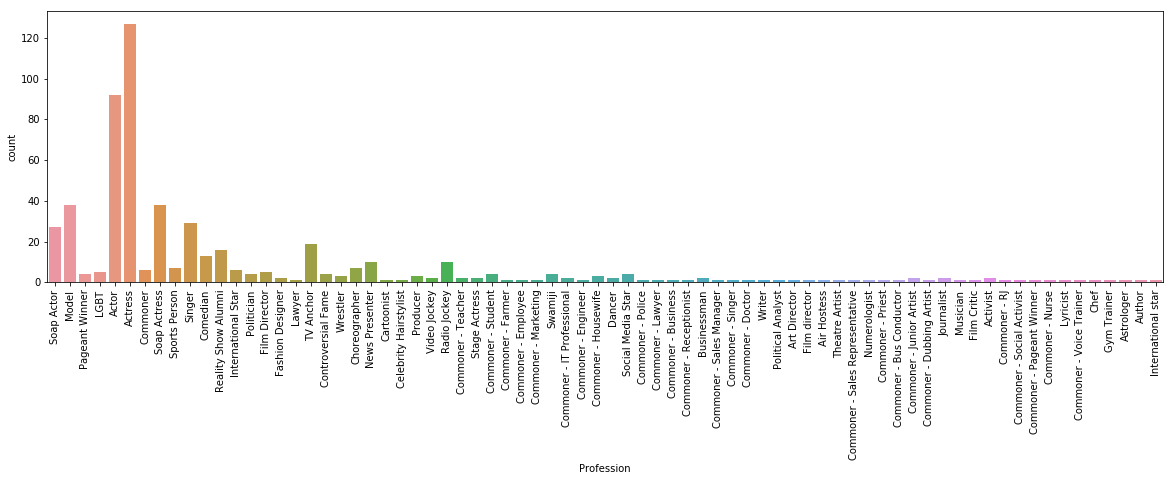

In [13]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20,5))
sns.countplot(x='Profession', data=bigg_boss)
plt.xticks(rotation=90)

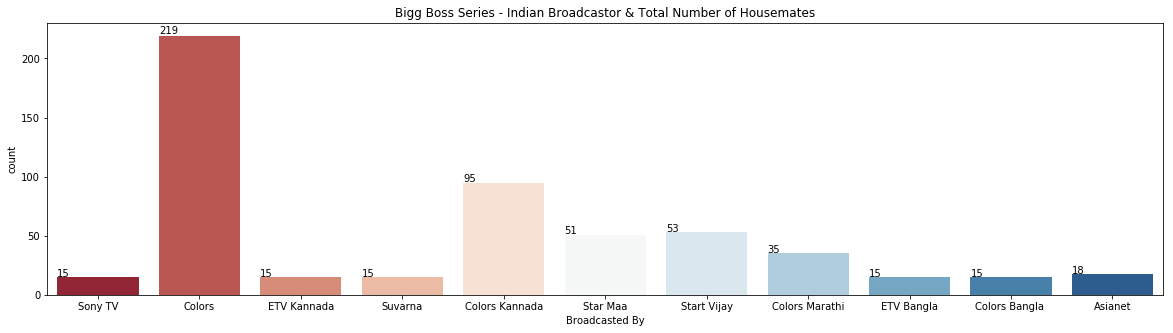

In [14]:
# Broadcastor
fig = plt.figure(figsize=(20,5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu')
ax.set_title('Bigg Boss Series - Indian Broadcastor & Total Number of Housemates')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next in the list

In [15]:
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan                8
Sudeep                     7
Kamal Haasan               3
Mahesh Manjrekar           2
Amitabh Bachchan           1
Arshad Warsi               1
Jeet                       1
Jr. NTR                    1
Mithun Chakraborthy        1
Mohanlal                   1
Nagarjuna                  1
Nani                       1
Salman Khan/Farah Khan     1
Salman Khan/Sanjay Dutt    1
Shilpa Shetty              1
Name: Season Number, dtype: int64

## In all Bigg Boss languages, and in all seasons, Female contestants are more

In [16]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts())

# Female         285
# Male           256
# Transgender      5

Female         285
Male           256
Transgender      5
Name: Gender, dtype: int64


### Only 5 Transgenders participated in all Indian languages

In [17]:
# Maximum TRP of Bigg Boss Hindi/India seasons
print("Maximum TRP",bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 10.33 

Language  Season Number
 Malayam              1


## https://satya-data.blogspot.com/2018/01/bigg-boss-data-set-bigg-boss.html

In [18]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
8,Hindi,1,Rahul Roy,Actor,Male,03-Nov-06,NaN,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,"1,00,00,000",Sony TV,4.0,2.72,0.0,0.0,1.0
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,17-Aug-08,NaN,NaN,No,98,15,17-Aug-08,22-Nov-08,Shilpa Shetty,"1,00,00,000",Colors,4.0,2.89,0.0,0.0,1.0
42,Hindi,3,Vindu Dara Singh,Actor,Male,04-Oct-09,NaN,NaN,No,84,15,04-Oct-09,26-Dec-09,Amitabh Bachchan,"1,00,00,000",Colors,7.0,2.83,0.0,0.0,1.0
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,03-Oct-10,NaN,NaN,No,96,16,03-Oct-10,08-Jan-11,Salman Khan,"1,00,00,000",Colors,4.0,4.95,0.0,2.0,1.0
62,Hindi,5,Juhi Parmar,Soap Actress,Female,02-Oct-11,NaN,NaN,No,98,18,02-Oct-11,07-Jan-12,Salman Khan/Sanjay Dutt,"1,00,00,000",Colors,4.0,4.19,0.0,1.0,1.0
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,07-Oct-12,NaN,NaN,No,97,19,07-Oct-12,12-Jan-13,Salman Khan,"50,00,000",Colors,6.0,3.81,0.0,1.0,1.0
102,Hindi,7,Gauhar Khan,Actress,Female,15-Sep-13,NaN,NaN,No,105,20,15-Sep-13,28-Dec-13,Salman Khan,"50,00,000",Colors,7.0,4.40,0.0,2.0,1.0
121,Hindi,8,Gautam Gulati,Actor,Male,21-Sep-14,NaN,NaN,No,105,19,21-Sep-14,03-Jan-15,Salman Khan/Farah Khan,"50,00,000",Colors,10.0,3.77,0.0,1.0,1.0
144,Hindi,9,Prince Narula,Reality Show Alumni,Male,11-Oct-15,NaN,NaN,No,105,20,11-Oct-15,23-Jan-16,Salman Khan,"50,00,000",Colors,6.0,2.90,0.0,4.0,1.0
165,Hindi,10,Manveer Gurjar,Commoner - Farmer,Male,16-Oct-16,NaN,NaN,No,105,18,16-Oct-16,28-Jan-17,Salman Khan,"50,00,000",Colors,7.0,3.54,0.0,4.0,1.0


In [19]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Profession'].value_counts()

Actor                  6
Actress                5
Soap Actress           4
Singer                 4
Reality Show Alumni    3
TV Anchor              2
Model                  1
Commoner               1
Film Director          1
Commoner - Farmer      1
Soap Actor             1
Name: Profession, dtype: int64

In [20]:
# Gender of Season title Winners
bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts()

# Male      20
# Female     9

Male      20
Female     9
Name: Gender, dtype: int64

In [21]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1,'Number of Evictions Faced'].value_counts().sort_index()

4.0     7
5.0     3
6.0     5
7.0     5
9.0     3
10.0    1
11.0    2
Name: Number of Evictions Faced, dtype: int64

## No wild card entry housemate won the Bigg Boss competition.

In [22]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Wild Card'].value_counts()

No    29
Name: Wild Card, dtype: int64

In [23]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1,'Number of re-entries'].value_counts()

0.0    26
Name: Number of re-entries, dtype: int64

In [24]:
# Bigg Boss winners Number of times elected as Captain
bigg_boss.loc[bigg_boss.Winner==1,'Number of times elected as Captain'].value_counts().sort_index()

0.0    5
1.0    6
2.0    5
3.0    1
4.0    2
Name: Number of times elected as Captain, dtype: int64

## BB Hindi Seasons

In [25]:
lang='Hindi'
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,3.0,2.72,0.0,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,6.0,2.72,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,Hindi,13,Khesari Lal Yadav,Actor,Male,NaN,NaN,NaN,Yes,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.00,NaN,NaN,NaN
230,Hindi,13,Shefali Zariwala,Actress,Female,NaN,NaN,NaN,Yes,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.00,NaN,1.0,NaN
231,Hindi,13,Arhaan Khan,Model,Male,NaN,NaN,NaN,Yes,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.00,NaN,NaN,NaN
232,Hindi,13,Himanshi Khurana,Singer,Female,NaN,NaN,NaN,Yes,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.00,NaN,NaN,NaN


In [26]:
# Bigg Boss Hindi Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
8,Hindi,1,Rahul Roy,Actor,Male,03-Nov-06,NaN,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,"1,00,00,000",Sony TV,4.0,2.72,0.0,0.0,1.0
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,17-Aug-08,NaN,NaN,No,98,15,17-Aug-08,22-Nov-08,Shilpa Shetty,"1,00,00,000",Colors,4.0,2.89,0.0,0.0,1.0
42,Hindi,3,Vindu Dara Singh,Actor,Male,04-Oct-09,NaN,NaN,No,84,15,04-Oct-09,26-Dec-09,Amitabh Bachchan,"1,00,00,000",Colors,7.0,2.83,0.0,0.0,1.0
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,03-Oct-10,NaN,NaN,No,96,16,03-Oct-10,08-Jan-11,Salman Khan,"1,00,00,000",Colors,4.0,4.95,0.0,2.0,1.0
62,Hindi,5,Juhi Parmar,Soap Actress,Female,02-Oct-11,NaN,NaN,No,98,18,02-Oct-11,07-Jan-12,Salman Khan/Sanjay Dutt,"1,00,00,000",Colors,4.0,4.19,0.0,1.0,1.0
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,07-Oct-12,NaN,NaN,No,97,19,07-Oct-12,12-Jan-13,Salman Khan,"50,00,000",Colors,6.0,3.81,0.0,1.0,1.0
102,Hindi,7,Gauhar Khan,Actress,Female,15-Sep-13,NaN,NaN,No,105,20,15-Sep-13,28-Dec-13,Salman Khan,"50,00,000",Colors,7.0,4.40,0.0,2.0,1.0
121,Hindi,8,Gautam Gulati,Actor,Male,21-Sep-14,NaN,NaN,No,105,19,21-Sep-14,03-Jan-15,Salman Khan/Farah Khan,"50,00,000",Colors,10.0,3.77,0.0,1.0,1.0
144,Hindi,9,Prince Narula,Reality Show Alumni,Male,11-Oct-15,NaN,NaN,No,105,20,11-Oct-15,23-Jan-16,Salman Khan,"50,00,000",Colors,6.0,2.90,0.0,4.0,1.0
165,Hindi,10,Manveer Gurjar,Commoner - Farmer,Male,16-Oct-16,NaN,NaN,No,105,18,16-Oct-16,28-Jan-17,Salman Khan,"50,00,000",Colors,7.0,3.54,0.0,4.0,1.0


In [27]:
# Bigg Boss Hindi current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
215,Hindi,13,Arti Singh,Soap Actress,Female,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,1.0,NaN
216,Hindi,13,Asim Riaz,Model,Male,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,NaN,NaN
218,Hindi,13,Devoleena BhattacharjeeÊ,Soap Actress,Female,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,1.0,NaN,NaN
220,Hindi,13,Mahira Sharma,Soap Actress,Female,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,NaN,NaN
221,Hindi,13,Paras ChhabraÊ,Soap Actor,Male,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,NaN,NaN
222,Hindi,13,Rashami Desai,Soap Actress,Female,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,1.0,NaN,NaN
224,Hindi,13,Shehnaaz Gill,Singer,Female,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,NaN,NaN
225,Hindi,13,Siddharth Shukla,Soap Actor,Male,29-Sep-19,NaN,NaN,No,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,NaN,NaN
227,Hindi,13,Vikas Pathak,Social Media Star,Male,NaN,NaN,NaN,Yes,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,NaN,NaN
229,Hindi,13,Khesari Lal Yadav,Actor,Male,NaN,NaN,NaN,Yes,105,20,29-Sep-19,12-Jan-20,Salman Khan,NaN,Colors,NaN,8.0,NaN,NaN,NaN


## Preparing Data for ML modelling

In [28]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                             75
Elimination Date                      450
Elimination Week Number               106
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                        19
Host Name                               0
Prize Money (INR)                      15
Broadcasted By                          0
Number of Evictions Faced              76
Average TRP                           196
Number of re-entries                   74
Number of times elected as Captain    193
Winner                                 28
dtype: int64

In [29]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [30]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

In [31]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [32]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,3.0,2.72,0.0,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,2006-11-03,NaT,1.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,6.0,2.72,0.0,0.0,0.0


In [33]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
541,Malayam,1,Shweta Menon,Actress,Female,2018-06-24,NaT,5.0,No,98,18,2018-06-24,2018-09-30,Mohanlal,0,Asianet,1.0,10.33,0.0,1.0,0.0
542,Malayam,1,Sreelakshmi Sreekumar,Actress,Female,2018-06-24,NaT,4.0,No,98,18,2018-06-24,2018-09-30,Mohanlal,0,Asianet,2.0,10.33,0.0,0.0,0.0
543,Malayam,1,Srinish Aravind,Soap Actor,Male,2018-06-24,NaT,14.0,No,98,18,2018-06-24,2018-09-30,Mohanlal,0,Asianet,7.0,10.33,0.0,2.0,0.0
544,Malayam,1,Anjali Ameer,Actress,Female,NaT,NaT,NaN,Yes,98,18,2018-06-24,2018-09-30,Mohanlal,0,Asianet,5.0,10.33,0.0,0.0,0.0
545,Malayam,1,Shiyas Kareem,Actor,Male,NaT,NaT,14.0,Yes,98,18,2018-06-24,2018-09-30,Mohanlal,0,Asianet,0.0,10.33,0.0,1.0,0.0


In [34]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
383,Telugu,2,Kireeti Damaraju,Actor,Male,2018-06-10,NaT,3.0,No,112,18,2018-06-10,2018-09-30,Nani,0,Star Maa,2.0,5.355886,0.0,NaN,0.0
424,Tamil,1,Vaiyapuri,Comedian,Male,2017-06-25,NaT,12.0,No,98,19,2017-06-25,2017-09-30,Kamal Haasan,0,Start Vijay,5.0,7.800000,0.0,NaN,0.0
505,Bengali,1,Manabi Banerjee,Author,Female,2013-06-17,NaT,3.0,No,90,15,2013-06-17,2013-09-14,Mithun Chakraborthy,0,ETV Bangla,1.0,2.900000,0.0,NaN,0.0
23,Hindi,2,Rahul Mahajan,Politician,Male,2008-08-17,NaT,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,0,Colors,4.0,2.890000,0.0,0.0,0.0
150,Hindi,9,Yuvika Chaudhary,Actress,Female,2015-10-11,NaT,4.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,0,Colors,2.0,2.900000,0.0,1.0,0.0
32,Hindi,3,Claudia Ciesla,Model,Female,2009-10-04,NaT,9.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,0,Colors,2.0,2.830000,0.0,0.0,0.0
61,Hindi,5,Gulabo Sapera,Choreographer,Female,2011-10-02,NaT,2.0,No,98,18,2011-10-02,2012-01-07,Salman Khan/Sanjay Dutt,0,Colors,1.0,4.190000,0.0,0.0,0.0
213,Hindi,12,Rohit SuchantiÊ,Soap Actor,Male,NaT,NaT,13.0,Yes,105,20,2018-09-16,2018-12-30,Salman Khan,0,Colors,5.0,4.990000,0.0,0.0,0.0
217,Hindi,13,Dalljiet Kaur,Soap Actress,Female,2019-09-29,NaT,2.0,No,105,20,2019-09-29,2020-01-12,Salman Khan,0,Colors,2.0,8.000000,0.0,0.0,0.0
95,Hindi,6,Mink Brar,Model,Female,NaT,NaT,9.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,0,Colors,2.0,3.810000,0.0,0.0,0.0


In [35]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
215,Hindi,13,Arti Singh,Soap Actress,Female,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,1.0,NaN
216,Hindi,13,Asim Riaz,Model,Male,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN,NaN
218,Hindi,13,Devoleena BhattacharjeeÊ,Soap Actress,Female,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,1.0,NaN,NaN
220,Hindi,13,Mahira Sharma,Soap Actress,Female,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN,NaN
221,Hindi,13,Paras ChhabraÊ,Soap Actor,Male,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN,NaN
222,Hindi,13,Rashami Desai,Soap Actress,Female,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,1.0,NaN,NaN
224,Hindi,13,Shehnaaz Gill,Singer,Female,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN,NaN
225,Hindi,13,Siddharth Shukla,Soap Actor,Male,2019-09-29,NaT,NaN,No,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN,NaN
227,Hindi,13,Vikas Pathak,Social Media Star,Male,NaT,NaT,NaN,Yes,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN,NaN
229,Hindi,13,Khesari Lal Yadav,Actor,Male,NaT,NaT,NaN,Yes,105,20,2019-09-29,2020-01-12,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN,NaN


In [36]:
BB_Hindi_participant = test[['Name']]
BB_Hindi_participant.reset_index(drop=True, inplace=True)
BB_Hindi_participant

,Name
0,Arti Singh
1,Asim Riaz
2,Devoleena BhattacharjeeÊ
3,Mahira Sharma
4,Paras ChhabraÊ
5,Rashami Desai
6,Shehnaaz Gill
7,Siddharth Shukla
8,Vikas Pathak
9,Khesari Lal Yadav


In [37]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Elimination Week Number"], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Elimination Week Number","Winner"], axis=1, inplace=True)

In [38]:
train.head()

,Language,Season Number,Profession,Gender,Wild Card,Season Length,Number of Housemates,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Soap Actor,Male,No,86,15,Arshad Warsi,0,Sony TV,3.0,2.72,0.0,0.0,0.0
1,Hindi,1,Model,Female,No,86,15,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
2,Hindi,1,Pageant Winner,Male,No,86,15,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
3,Hindi,1,LGBT,Transgender,No,86,15,Arshad Warsi,0,Sony TV,1.0,2.72,0.0,0.0,0.0
4,Hindi,1,Model,Female,No,86,15,Arshad Warsi,0,Sony TV,6.0,2.72,0.0,0.0,0.0


In [39]:
test.head(17)

,Language,Season Number,Profession,Gender,Wild Card,Season Length,Number of Housemates,Host Name,Prize Money (INR),Broadcasted By,Number of Evictions Faced,Average TRP,Number of re-entries,Number of times elected as Captain
215,Hindi,13,Soap Actress,Female,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,1.0
216,Hindi,13,Model,Male,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN
218,Hindi,13,Soap Actress,Female,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,1.0,NaN
220,Hindi,13,Soap Actress,Female,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN
221,Hindi,13,Soap Actor,Male,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN
222,Hindi,13,Soap Actress,Female,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,1.0,NaN
224,Hindi,13,Singer,Female,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN
225,Hindi,13,Soap Actor,Male,No,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN
227,Hindi,13,Social Media Star,Male,Yes,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN
229,Hindi,13,Actor,Male,Yes,105,20,Salman Khan,NaN,Colors,1.0,8.0,0.0,NaN


In [40]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.401544
1.0     5.598456
Name: Winner, dtype: float64


In [41]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [42]:
print(train2.shape)
print(test.shape)

(518, 174)
(14, 174)


In [43]:
train2.isnull().sum().sort_values(ascending=False)

Number of times elected as Captain_5.0    0
Profession_Commoner - Teacher             0
Profession_Gym Trainer                    0
Profession_Film director                  0
Profession_Film Director                  0
                                         ..
Host Name_Mithun Chakraborthy             0
Host Name_Mahesh Manjrekar                0
Host Name_Kamal Haasan                    0
Host Name_Jr. NTR                         0
Language_Hindi                            0
Length: 174, dtype: int64

In [44]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Profession_Actor,Profession_Actress,Profession_Air Hostess,Profession_Art Director,Profession_Astrologer,Profession_Author,Profession_Businessman,...,Average TRP_2.89,Average TRP_2.9,Average TRP_3.54,Average TRP_3.77,Average TRP_3.81,Average TRP_4.19,Average TRP_4.4,Average TRP_4.7,Average TRP_4.95,Average TRP_4.99,Average TRP_5.355885714285708,Average TRP_6.5,Average TRP_7.64,Average TRP_7.8,Average TRP_8.0,Average TRP_8.2,Average TRP_8.8,Average TRP_10.33,Number of re-entries_1.0,Number of re-entries_2.0,Number of times elected as Captain_1.0,Number of times elected as Captain_2.0,Number of times elected as Captain_3.0,Number of times elected as Captain_4.0,Number of times elected as Captain_5.0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [46]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2019)
print(x_train.shape, x_val.shape)

(362, 174) (156, 174)


In [47]:
x_train.isnull().sum().sort_values(ascending=False)

Number of times elected as Captain_5.0    0
Profession_Commoner - Teacher             0
Profession_Gym Trainer                    0
Profession_Film director                  0
Profession_Film Director                  0
                                         ..
Host Name_Mithun Chakraborthy             0
Host Name_Mahesh Manjrekar                0
Host Name_Kamal Haasan                    0
Host Name_Jr. NTR                         0
Language_Hindi                            0
Length: 174, dtype: int64

## Machine Learning Modelling

In [48]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)

In [49]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2019, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 92.37516869095816
F1 score for C=1: 97.86467712889117
F1 score for C=10: 98.63067581188386
F1 score for C=100: 99.33868600535268
F1 score for C=1000: 99.33868600535268


In [50]:
logi = LogisticRegression(random_state=2019, C=100).fit(x_train, y_train)
logi

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2019, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 99.33868600535268
Accuracy Score - 99.35897435897436


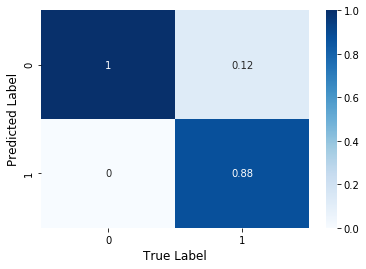

In [52]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.88

In [53]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_Hindi_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg[['Name','Predicted_Winner']]

,Name,Predicted_Winner
0,Arti Singh,0.000167
1,Asim Riaz,0.000050
2,Devoleena BhattacharjeeÊ,0.000068
3,Mahira Sharma,0.000187
4,Paras ChhabraÊ,0.000042
5,Rashami Desai,0.000068
6,Shehnaaz Gill,0.000534
7,Siddharth Shukla,0.000042
8,Vikas Pathak,0.000020
9,Khesari Lal Yadav,0.000013


## Predicted Winner for Bigg Boss Hindi Season 13, as per Logistic Regression

In [54]:
# Predicted Winner for Bigg Boss Hindi Season 13, as per Logistic Regression
winner_lg.iloc[np.argwhere(winner_lg.Predicted_Winner == np.amax(winner_lg.Predicted_Winner)).flatten().tolist()]

,Name,Predicted_Winner
6,Shehnaaz Gill,0.000534


In [55]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=2019).fit(x_train, y_train)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=2019,
                       verbose=0, warm_start=False)

In [56]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=300 accuracy 99.33

F1 Score - 99.33868600535268
Accuracy Score - 99.35897435897436


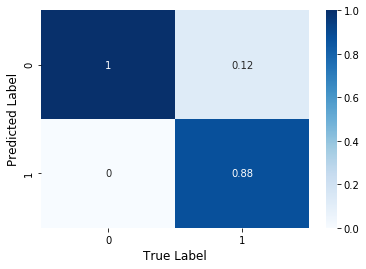

In [57]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.88

In [58]:
predicted_val_rf = rf.predict_proba(test)[:,1]
winner_rf = pd.concat([BB_Hindi_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf[['Name','Predicted_Winner']]

,Name,Predicted_Winner
0,Arti Singh,0.026667
1,Asim Riaz,0.000000
2,Devoleena BhattacharjeeÊ,0.013333
3,Mahira Sharma,0.013333
4,Paras ChhabraÊ,0.000000
5,Rashami Desai,0.013333
6,Shehnaaz Gill,0.010000
7,Siddharth Shukla,0.000000
8,Vikas Pathak,0.000000
9,Khesari Lal Yadav,0.000000


## Predicted Winner for Bigg Boss Hindi Season 13, as per Random Forest

In [59]:
# Predicted Winner for Bigg Boss Hindi Season 13, as per Random Forest
winner_rf.iloc[np.argwhere(winner_rf.Predicted_Winner == np.amax(winner_rf.Predicted_Winner)).flatten().tolist()]

,Name,Predicted_Winner
0,Arti Singh,0.026667


## Neaural Networks (MLP)

In [60]:
NN = MLPClassifier(random_state=2019)
#NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(500, 20), random_state=2019)
NN.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [61]:
predicted_val_nn = NN.predict_proba(x_val)[:,1]
y_predicted_val = (predicted_val_nn > 0.05).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 95.34949069195645
Accuracy Score - 94.87179487179486


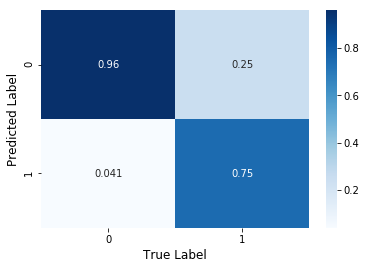

In [62]:
# Confusion Matrix
plot_confusion_matrix()

In [63]:
predicted_val_nn = NN.predict(test)
winner_nn = pd.concat([BB_Hindi_participant, pd.DataFrame(predicted_val_nn, columns=['Predicted_Winner'])],axis=1)
winner_nn[['Name','Predicted_Winner']]

,Name,Predicted_Winner
0,Arti Singh,0.0
1,Asim Riaz,0.0
2,Devoleena BhattacharjeeÊ,0.0
3,Mahira Sharma,0.0
4,Paras ChhabraÊ,0.0
5,Rashami Desai,0.0
6,Shehnaaz Gill,0.0
7,Siddharth Shukla,0.0
8,Vikas Pathak,0.0
9,Khesari Lal Yadav,0.0


In [64]:
# Predicted Winner for Bigg Boss Hindi Season 13, as per Neaural Networks (Multi Layer Perceptron)
# winner_nn.iloc[np.argwhere(winner_nn.Predicted_Winner == np.amax(winner_nn.Predicted_Winner)).flatten().tolist()]